In [1]:
import pathlib as pl
import pandas
import matplotlib.pyplot as plt

import flopy
from defaults import *

In [2]:
parallel_dir = get_parallel_dir()
base_dir = get_base_dir()

parallel_sim = flopy.mf6.MFSimulation.load(sim_ws=parallel_dir, verbosity_level=0)
nr_models = len(parallel_sim.model_names)

In [3]:
csv_inner_base = pl.Path.cwd().joinpath(base_dir).joinpath("inner.csv")
assert pl.Path.is_file(csv_inner_base)

csv_inner_par = [pl.Path.cwd().joinpath(parallel_dir).joinpath(f"inner.p{irank}.csv") 
                 for irank in range(nr_models)]
assert pl.Path.is_file(csv_inner_par[-1])

In [4]:
df_base = pandas.read_csv(csv_inner_base)
df_par = [pandas.read_csv(f) for f in csv_inner_par]

total_inners_base = df_base.iloc[-1]["total_inner_iterations"]
total_inners_par = df_par[0].iloc[-1]["total_inner_iterations"]
print("Total inner iterations base:", total_inners_base, ", parallel:", total_inners_par)

Total inner iterations base: 390.0 , parallel: 398.0


In [5]:
plot_variable = "solution_inner_dvmax"

Text(0, 0.5, 'solution_inner_dvmax')

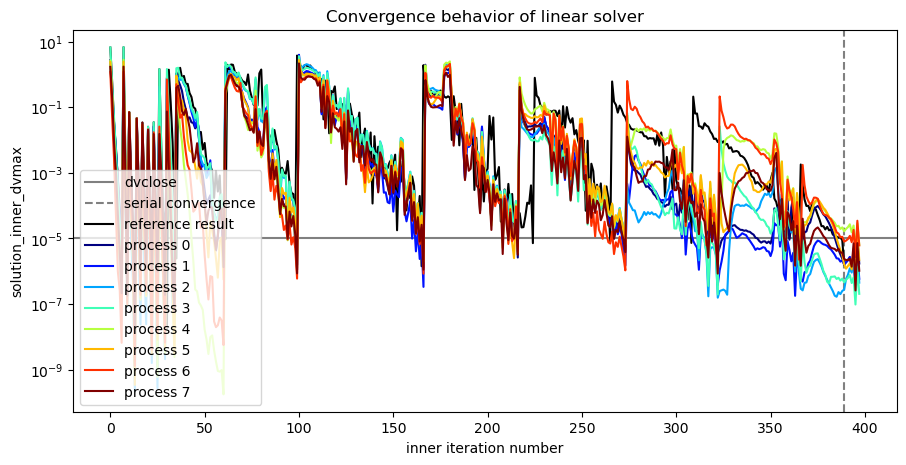

In [31]:
fig = plt.figure(figsize=(1.5*figwidth,0.7*figheight))
colors = plt.cm.jet(np.linspace(0,1,nr_models))

dvclose = parallel_sim.get_package("IMS").inner_dvclose.data
plt.axhline(dvclose, color="grey", label="dvclose")
plt.axvline(total_inners_base - 1, color="grey", linestyle="dashed", label="serial convergence")

dvmax = abs(df_base[plot_variable])
plt.plot(dvmax, label='reference result', color="black")
for i, df in enumerate(df_par):
  dvmax = abs(df[plot_variable])
  plt.plot(dvmax, label=f"process {i}", color=colors[i])

plt.yscale("log")
plt.legend()
plt.title("Convergence behavior of linear solver")
plt.xlabel("inner iteration number")
plt.ylabel(plot_variable)